In [ ]:
# (GPT) Federated Learning from scratch (FedAvg) — numpy implementation 
# This code creates a simple federated learning simulation using logistic regression (binary classification).
# - No external ML libraries required (only numpy, matplotlib)
# - Simulates non-iid data across clients
# - Implements FedAvg: local client SGD updates, server averages parameters weighted by client data sizes
# - Plots training loss and test accuracy
#
# Run in this notebook environment. Outputs: training progress printed, and two plots (global loss & test accuracy).
# If you want multi-class or neural-net, I can extend it — but this is intentionally small and transparent.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
np.random.seed(0)



In [3]:
# -----------------------------
# Utilities: model, loss, grads
# -----------------------------
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_proba(X, params):
    W, b = params['W'], params['b']
    return sigmoid(X.dot(W) + b)

def predict_label(X, params, threshold=0.5):
    return (predict_proba(X, params) >= threshold).astype(int)

def bce_loss(y_true, y_prob, eps=1e-12):
    y_prob = np.clip(y_prob, eps, 1-eps)
    return -np.mean(y_true * np.log(y_prob) + (1-y_true)*np.log(1-y_prob))

def compute_grads(X, y, params):
    # returns gradients for W and b (mean over samples)
    N = X.shape[0]
    probs = predict_proba(X, params)
    error = probs - y  # shape (N,)
    grad_W = (X.T.dot(error)) / N  # (d,)
    grad_b = np.mean(error)
    return {'W': grad_W, 'b': grad_b}


# -----------------------------
# Synthetic non-iid dataset
# -----------------------------
def make_non_iid_data(num_clients=5, samples_per_client=200, dim=10, non_iid_strength=0.9):
    """
    Creates binary classification data across clients.
    Each client has a local linear separator with some shared global direction
    non_iid_strength in [0,1] controls how different each client's separator is:
      0 -> identical across clients (iid)
      1 -> totally different per client
    """
    total = num_clients * samples_per_client
    # Global direction
    global_dir = np.random.randn(dim)
    global_dir /= np.linalg.norm(global_dir)
    
    X_all = []
    y_all = []
    client_partitions = []
    for c in range(num_clients):
        # local direction is a mix of global_dir and a random vector
        local_random = np.random.randn(dim)
        local_random /= np.linalg.norm(local_random)
        dir_c = (1 - non_iid_strength) * global_dir + non_iid_strength * local_random
        dir_c /= np.linalg.norm(dir_c)
        # Sample features
        Xc = np.random.randn(samples_per_client, dim)
        # make label according to linear separator with some noise
        logits = Xc.dot(dir_c) + 0.2 * np.random.randn(samples_per_client)
        yc = (logits > 0).astype(int)
        start = len(X_all)
        X_all.append(Xc)
        y_all.append(yc)
        client_partitions.append((start, start + samples_per_client))
    # Stack
    X_all = np.vstack(X_all)
    y_all = np.hstack(y_all)
    # Shuffle globally and create a test set holdout
    idx = np.random.permutation(total)
    X_all = X_all[idx]
    y_all = y_all[idx]
    # split: 80% train (distributed), 20% test (centralized)
    split = int(0.8 * total)
    X_train = X_all[:split]
    y_train = y_all[:split]
    X_test = X_all[split:]
    y_test = y_all[split:]
    # To provide client-local views, slice from original per-client arrays (not shuffled)
    # We'll re-create per-client local datasets from the original generation to preserve non-iid partitions.
    client_data = []
    for c in range(num_clients):
        Xc = X_all[c * samples_per_client:(c+1) * samples_per_client]
        yc = y_all[c * samples_per_client:(c+1) * samples_per_client]
        client_data.append((Xc, yc))
    return client_data, (X_test, y_test)


# -----------------------------
# Local client training routine
# -----------------------------
def local_train(X, y, params, local_epochs=1, batch_size=16, lr=0.1):
    """
    Performs local SGD (logistic regression) on the client's data.
    Returns updated params and number of samples.
    """
    W = params['W'].copy()
    b = params['b']
    N = X.shape[0]
    indices = np.arange(N)
    for ep in range(local_epochs):
        np.random.shuffle(indices)
        for i in range(0, N, batch_size):
            batch_idx = indices[i:i+batch_size]
            Xb = X[batch_idx]
            yb = y[batch_idx]
            grads = compute_grads(Xb, yb, {'W': W, 'b': b})
            W -= lr * grads['W']
            b -= lr * grads['b']
    return {'W': W, 'b': b}, N


# -----------------------------
# Federated training (FedAvg)
# -----------------------------
def federated_train(client_data, test_data, rounds=30, clients_per_round=None,
                    local_epochs=1, batch_size=16, lr=0.1, eval_every=1):
    num_clients = len(client_data)
    dim = client_data[0][0].shape[1]
    # initialize global params
    global_params = {'W': np.zeros(dim), 'b': 0.0}
    history = {'round': [], 'test_loss': [], 'test_acc': []}
    
    if clients_per_round is None:
        clients_per_round = num_clients  # full participation by default
    
    for r in range(1, rounds+1):
        # sample clients for this round
        selected = np.random.choice(num_clients, clients_per_round, replace=False)
        local_updates = []
        local_sizes = []
        for c in selected:
            Xc, yc = client_data[c]
            updated_params, Nc = local_train(Xc, yc, global_params, local_epochs=local_epochs,
                                             batch_size=batch_size, lr=lr)
            local_updates.append(updated_params)
            local_sizes.append(Nc)
        # aggregate (weighted average by client data size)
        total_samples = sum(local_sizes)
        W_new = np.zeros_like(global_params['W'])
        b_new = 0.0
        for upd, sz in zip(local_updates, local_sizes):
            W_new += (sz / total_samples) * upd['W']
            b_new += (sz / total_samples) * upd['b']
        global_params = {'W': W_new, 'b': b_new}
        
        # evaluate
        if r % eval_every == 0:
            X_test, y_test = test_data
            probs = predict_proba(X_test, global_params)
            loss = bce_loss(y_test, probs)
            preds = (probs >= 0.5).astype(int)
            acc = accuracy_score(y_test, preds)
            history['round'].append(r)
            history['test_loss'].append(loss)
            history['test_acc'].append(acc)
            print(f"Round {r:03d} | Test loss: {loss:.4f} | Test acc: {acc:.4f}")
    return global_params, history



Round 002 | Test loss: 0.6788 | Test acc: 0.5850
Round 004 | Test loss: 0.6740 | Test acc: 0.5858
Round 006 | Test loss: 0.6922 | Test acc: 0.5342
Round 008 | Test loss: 0.6725 | Test acc: 0.5867
Round 010 | Test loss: 0.6917 | Test acc: 0.5433
Round 012 | Test loss: 0.6919 | Test acc: 0.5642
Round 014 | Test loss: 0.6882 | Test acc: 0.5425
Round 016 | Test loss: 0.6836 | Test acc: 0.5650
Round 018 | Test loss: 0.6805 | Test acc: 0.5733
Round 020 | Test loss: 0.6911 | Test acc: 0.5567
Round 022 | Test loss: 0.6948 | Test acc: 0.5425
Round 024 | Test loss: 0.6830 | Test acc: 0.5500
Round 026 | Test loss: 0.6844 | Test acc: 0.5608
Round 028 | Test loss: 0.6854 | Test acc: 0.5725
Round 030 | Test loss: 0.6814 | Test acc: 0.5533
Round 032 | Test loss: 0.6757 | Test acc: 0.5808
Round 034 | Test loss: 0.6894 | Test acc: 0.5758
Round 036 | Test loss: 0.6829 | Test acc: 0.5642
Round 038 | Test loss: 0.6878 | Test acc: 0.5700
Round 040 | Test loss: 0.6829 | Test acc: 0.5800
Round 042 | Test los

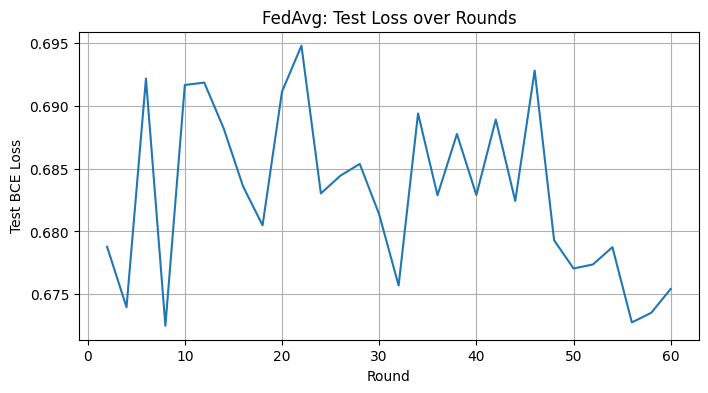

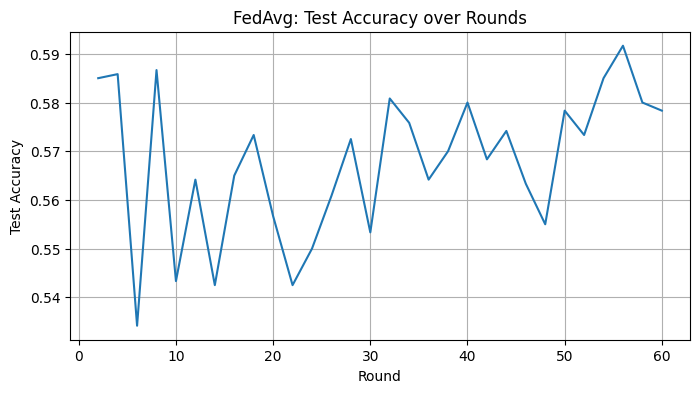


Final federated model -- Test loss: 0.6754 | Test acc: 0.5783


In [5]:

# -----------------------------
# Quick experiment
# -----------------------------
num_clients = 20
samples_per_client = 300
dim = 12
client_data, test_data = make_non_iid_data(num_clients=num_clients,
                                           samples_per_client=samples_per_client,
                                           dim=dim,
                                           non_iid_strength=0.9)

# Hyperparams
rounds = 60
clients_per_round = 4   # partial participation
local_epochs = 3
batch_size = 32
lr = 0.5

global_params, history = federated_train(client_data, test_data,
                                         rounds=rounds,
                                         clients_per_round=clients_per_round,
                                         local_epochs=local_epochs,
                                         batch_size=batch_size,
                                         lr=lr,
                                         eval_every=2)

# Baseline: centralized training on same total data for comparison
X_central = np.vstack([c[0] for c in client_data])
y_central = np.hstack([c[1] for c in client_data])

def centralized_train(X, y, test_data, epochs=50, batch_size=64, lr=0.1):
    dim = X.shape[1]
    params = {'W': np.zeros(dim), 'b': 0.0}
    N = X.shape[0]
    indices = np.arange(N)
    for ep in range(epochs):
        np.random.shuffle(indices)
        for i in range(0, N, batch_size):
            batch_idx = indices[i:i+batch_size]
            Xb = X[batch_idx]
            yb = y[batch_idx]
            grads = compute_grads(Xb, yb, params)
            params['W'] -= lr * grads['W']
            params['b'] -= lr * grads['b']
    # eval
    probs = predict_proba(test_data[0], params)
    loss = bce_loss(test_data[1], probs)
    acc = accuracy_score(test_data[1], (probs>=0.5).astype(int))
    return params, loss, acc

central_params, cent_loss, cent_acc = centralized_train(X_central, y_central, test_data,
                                                        epochs=200, batch_size=64, lr=0.1)
print("\nCentralized baseline -- Test loss: {:.4f} | Test acc: {:.4f}".format(cent_loss, cent_acc))

# -----------------------------
# Plots: test loss and accuracy
# -----------------------------
plt.figure(figsize=(8,4))
plt.plot(history['round'], history['test_loss'])
plt.xlabel('Round')
plt.ylabel('Test BCE Loss')
plt.title('FedAvg: Test Loss over Rounds')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history['round'], history['test_acc'])
plt.xlabel('Round')
plt.ylabel('Test Accuracy')
plt.title('FedAvg: Test Accuracy over Rounds')
plt.grid(True)
plt.show()

# Print final numbers
final_probs = predict_proba(test_data[0], global_params)
final_loss = bce_loss(test_data[1], final_probs)
final_acc = accuracy_score(test_data[1], (final_probs>=0.5).astype(int))
print(f"\nFinal federated model -- Test loss: {final_loss:.4f} | Test acc: {final_acc:.4f}")

